### Payout when taking random action each round

The actions and corresponding payouts of the average casino player are simulated using the Open AI blackjack environment mentioned above. Each round, either hit or stick is chosen at random.

[2017-08-05 12:47:26,236] Making new env: Blackjack-v0


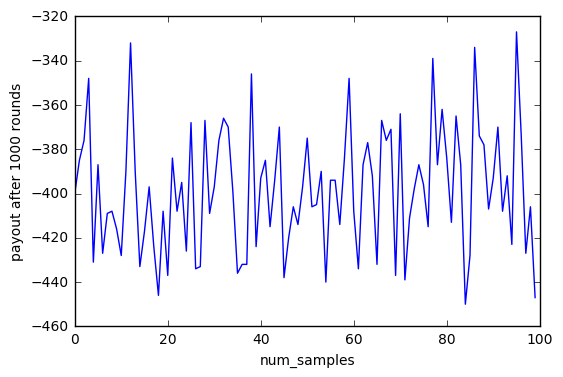

Average payout after 1000 rounds is -398.38


In [10]:
import gym
env = gym.make('Blackjack-v0')
import matplotlib.pyplot as plt
env.reset()

num_rounds = 1000
num_samples = 100

average_payouts = []

for sample in range(num_samples):
    round = 1
    total_payout = 0
    while round <= num_rounds:
        action = env.action_space.sample()   
        # print (env._get_obs())
        # print (action)
        obs, payout, is_done, _ = env.step(action)
        # print (obs, payout, is_done)
        total_payout += payout
        if is_done:
            env.reset()
            round += 1
    average_payouts.append(total_payout)

plt.plot(average_payouts)            
    
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

### Payout when using normal play strategy
Strategy from figure 11 [here](https://pdfs.semanticscholar.org/e1dd/06616e2d18179da7a3643cb3faab95222c8b.pdf)

In [2]:
def normal_strategy(player_sum, dealer_up_card):
    """
    Returns appropriate action from a 2D array storing actions
    Actions obtained from figure 11 here- https://pdfs.semanticscholar.org/e1dd/06616e2d18179da7a3643cb3faab95222c8b.pdf
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*8 # 2 to 9
    actions.append([1]*4 + [0]*2 + [1]*4) #10
    actions.append([1] + [0]*6 + [1]*3) #11
    actions.append([0] + [1]*9) #12
    actions.append([0]*2 + [1]*8) #13
    actions.append([0]*1 + [1]*9) #14
    actions.append([0]*2 + [1]*8) #15
    actions.append([0]*5 + [1]*5) #16
    actions.append([0]*4 + [1]*6) #17
    actions.extend([[0]*10]*4) # 18 to 21
    
    # dealer_up_card-2 takes care of input 1 which correcly looks up last column
    return actions[player_sum-2][dealer_up_card-2]

assert (normal_strategy(15, 2)) == 0
assert (normal_strategy(15, 1)) == 1


num_rounds = 1000
num_samples = 100
total_payout = 0

for _ in range(num_samples):
    round = 1
    while round <= num_rounds:
        player_sum, dealer_up_card, is_done = (env._get_obs())
        action = normal_strategy(player_sum, dealer_up_card)
        # print (env._get_obs())
        # print (action)
        obs, payout, is_done, _ = env.step(action)
        # print (obs, payout, is_done)
        total_payout += payout
        if is_done:
            env.reset()
            round += 1
    
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/num_samples))


Average payout after 1000 rounds is -98.83


### Agent

In [13]:
import random

class Agent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, num_episodes_to_train=30000):
        self.env = env

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(self.env.action_space.n))

        # Set parameters of the learning agent
        self.Q = dict()          # Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future

        # epsilon will reduce linearly until it reaches 0 based on num_episodes_to_train
        # epsilon drops to 90% of its inital value in the first 30% of num_episodes_to_train
        # epsilon then drops to 10% of its initial value in the next 40% of num_episodes_to_train
        # epsilon finally becomes 0 in the final 30% of num_episodes_to_train
        self.num_episodes_to_train = num_episodes_to_train # Change epsilon each episode based on this
        self.small_decrement = (0.1 * epsilon) / (0.3 * num_episodes_to_train) # reduces epsilon slowly
        self.big_decrement = (0.8 * epsilon) / (0.4 * num_episodes_to_train) # reduces epilon faster

        self.num_episodes_to_train_left = num_episodes_to_train

    def update_parameters(self):
        """
        Update epsilon and alpha before each episode
        Set them to 0 if not learning
        """
        if self.num_episodes_to_train_left > 0.7 * self.num_episodes_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_episodes_to_train_left > 0.3 * self.num_episodes_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_episodes_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0

        self.num_episodes_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)

        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        if random.random() > self.epsilon:
            maxQ = self.get_maxQ(observation)

            # multiple actions could have maxQ- pick one at random in that case
            # this is also the case when the Q value for this observation were just set to 0.0
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)

        self.update_parameters()

        return action


    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives an award.
        This function does not consider future rewards
        when conducting learning.
        """

        # Q = Q*(1-alpha) + alpha(reward + discount * utility of next observation)
        # Q = Q - Q * alpha + alpha(reward + discount * self.get_maxQ(next_observation))
        # Q = Q - alpha (-Q + reward + discount * self.get_maxQ(next_observation))
        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])

### Running algorithm by training over different number of episodes

[2017-08-05 02:28:30,023] Making new env: Blackjack-v0


Average payout after 1000 rounds after training for 200 episodes is -262.0
Average payout after 1000 rounds after training for 400 episodes is -195.0
Average payout after 1000 rounds after training for 600 episodes is -236.0
Average payout after 1000 rounds after training for 800 episodes is -188.6
Average payout after 1000 rounds after training for 1000 episodes is -244.8
Average payout after 1000 rounds after training for 1200 episodes is -232.6
Average payout after 1000 rounds after training for 1400 episodes is -252.0
Average payout after 1000 rounds after training for 1600 episodes is -184.4
Average payout after 1000 rounds after training for 1800 episodes is -201.0
Average payout after 1000 rounds after training for 2000 episodes is -183.2


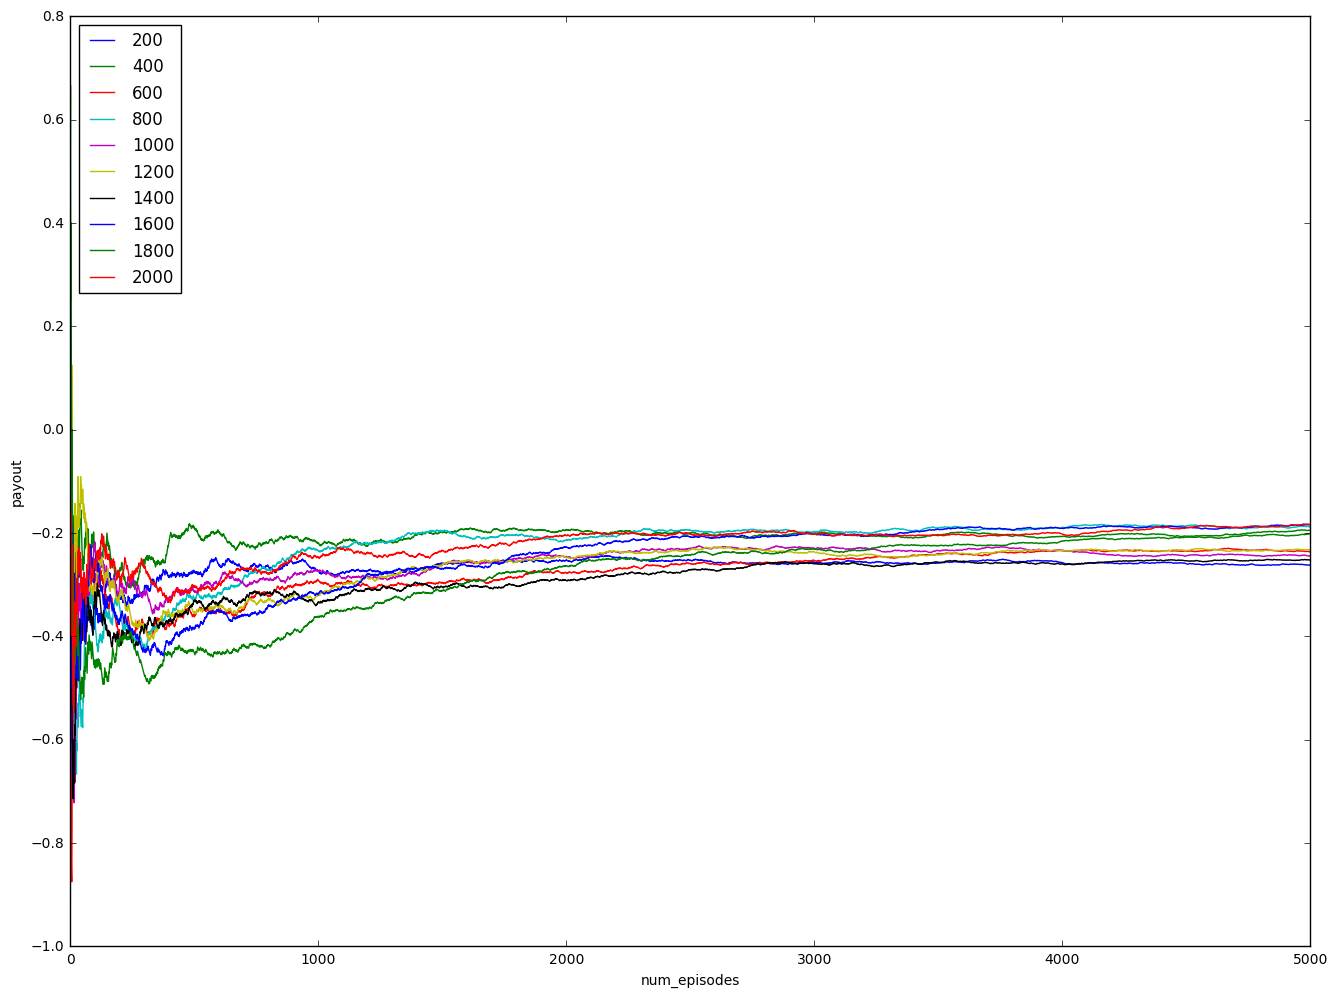

In [19]:
import gym
import matplotlib.pyplot as plt
from gym import wrappers
env = gym.make('Blackjack-v0')

num_rounds = 1000
num_samples = 5


num_episodes_values = range(200, 2200, 200)

plt.figure(num=None, figsize=(16, 12))
                          
for num_episodes_value in num_episodes_values:
    total_payout = 0
    average_payouts = []
    agent = Agent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=num_episodes_value)

    observation = env.reset()
    for sample in range(num_samples):
        round = 1
        while round <= num_rounds:
            action = agent.choose_action(observation)
            next_observation, payout, is_done, _ = env.step(action)
            agent.learn(observation, action, payout, next_observation)
            total_payout += payout
            observation = next_observation
            if is_done:
                observation = env.reset()
                round += 1
                average_payouts.append(total_payout/(sample*num_rounds + round))

    plt.plot(average_payouts)
    print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/(num_samples)))
    
plt.xlabel('num_episodes')
plt.ylabel('payout')
plt.legend(["{}".format(i) for i in num_episodes_values], loc='upper left')
plt.show()
env.close()



#### Rate of decrease of epsilon
Epsilon is also plotted during the training process to showcase the rate of decrease.

[2017-08-05 12:59:53,811] Making new env: Blackjack-v0


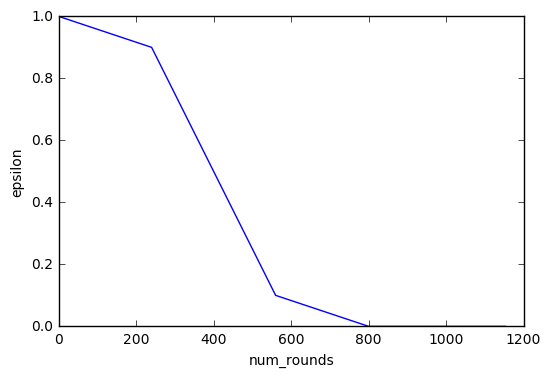

Average payout after 800 rounds is -225.0


In [16]:
env = gym.make('Blackjack-v0')
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)

total_payout = 0
average_payouts = []
agent = Agent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=800)

num_rounds = 800
num_samples = 1


observation = env.reset()
for sample in range(num_samples):
    round = 1
    epsilon_values = []
    while round <= num_rounds:
        epsilon_values.append(agent.epsilon)
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            observation = env.reset()
            round += 1
            average_payouts.append(total_payout/(sample*num_rounds + round))

plt.figure(2)
plt.xlabel("num_rounds")
plt.ylabel("epsilon")
plt.plot(epsilon_values)
plt.show()
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/(num_samples)))

### Final Model

The final model is built by picking the best parameter

[2017-08-05 13:50:43,852] Making new env: Blackjack-v0


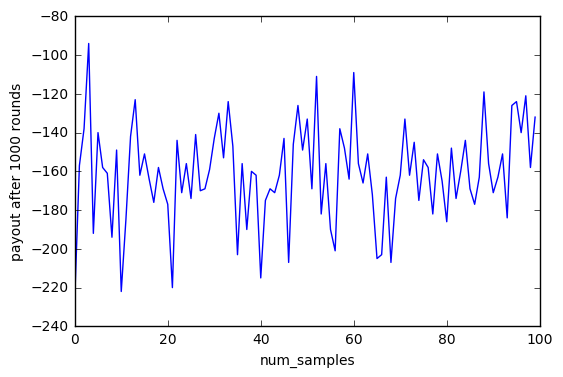

Average payout after 1000 rounds is -161.24


In [26]:
env = gym.make('Blackjack-v0')
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt

total_payout = 0
agent = Agent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=800)

num_rounds = 1000
num_samples = 100

average_payouts = []

observation = env.reset()
for sample in range(num_samples):
    round = 1
    total_payout = 0
    while round <= num_rounds:
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            observation = env.reset()
            round += 1
    average_payouts.append(total_payout)

plt.plot(average_payouts)            
    
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))